# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Tasklist 13 and 14: Simple Linear Regression. Multiple Linear Regression.

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

***

### Intro 

The goal of this Tasklist is to consolidate our knowledge of theoretical and practical insights provided in sessions 13 and 14 on (Multiple) Linear Regression. So far we have gone through simple and multiple linear regressions, parametric bootstrap and part and partial correlation. Looking back at the things that we have learned in the previous sessions we are now beginning to develop a full circle of neccessary steps in one basic data science project. 

In this tasklist we are going to use [Car Price Prediction](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction) data set from Kaggle. Read about the problem statement and the goal of the study from the link provided. **The only thing that needs to happen with the Car Price Prediction dataset here is for you to study and understand the Linear Regression Modeling of this data set as it is provided in this notebook.**

**YOUR REAL TASK is to analyze something else:** the **Market Mix data** provided as `market_mix.csv` in the `_data` directory of this session (the source file is found in the [veer064/Linear-Regression](https://github.com/veer064/Linear-Regression) GitHub repo). **The only thing that you need to do about the Market Mix data set is to use Multiple Linear Regression to predict the `NewVolSales` variable and inspect the multicolinearity present in the model.** So, first study the analysis of the Car Price Prediction as it is provided here, and then simply load `market_mix.csv`, clean all cell contents, and repeat everything that is done with Multiple Linear Regression in the Car Price Prediction study on the Market Mix data set where your outcome variable will be `NewVolSales`.

Data is provided in two files in `_data` folder. Namely:
- `car_prices.csv` - file with data we are going to work with,
- `data_dictionary.xlsx` - file that contains descriptions for each column in CSV file. **Warning** `carCompany` column from the dictionary is named `CarName` in CSV file.

We will use words column, feature, predictor interchangably though the tasklist, so do not let that confuse you.

**We strongly suggest studying Sessions 13 and 14 thoroughly and the two texts provided in the References section of this TaskList before proceeding.**

Also, idea is to use Python libraries we have introduced in Sessions 13 and 14.


Let's start by importing neccessary libraries.

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
import os 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats 

from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Like we said, we have the data set in `_data` folder. Let's load it.

In [9]:
data_dir = os.path.join(os.getcwd(),'_data')
for roots,dirs,files in os.walk(data_dir):
    print(files)

['car_prices.csv', 'data_dictionary.xlsx', 'Fish.csv', 'market_mix.csv']


In [10]:
full_path = os.path.join(data_dir,'car_prices.csv')
df=pd.read_csv(full_path)
df.shape #205,26

(205, 26)

Before we go any further, we will define helper methods for easier preview of model performance analysis. It is not necessary to understand the code for the following two methods at hand in order to proceed with the tasks.

In [11]:
# define a method that will return metrics for plotting influential points
def get_influential_points_summary(model: RegressionResultsWrapper, k: int = 1):
    model_inf = model.get_influence()
    # inf_frame = model_inf.summary_frame()
    # w_cookD = np.argwhere(model_inf.cooks_distance[0] > 1)
    n = len(model.resid)
    # w_leverage = np.argwhere(model_inf.hat_matrix_diag > 2*(k+1)/n)

    inf_plot_frame = pd.DataFrame(columns=['Residuals', 'Leverage', 'Cook Dist.'])

    inf_plot_frame['Residuals'] = model.resid
    inf_plot_frame['Leverage'] = model_inf.hat_matrix_diag
    inf_plot_frame['Cook Dist.'] = model_inf.cooks_distance[0]

    return inf_plot_frame

In [12]:
# define method to plot model performance analyis
def plot_model_analysis(model: RegressionResultsWrapper, target) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.4, wspace=.4)
    
    axes = axes.flatten()

    sns.histplot(model.resid, element='step', linewidth=.0, ax=axes[0]);
    sns.despine()
    # axes[0].grid(alpha=.3)
    axes[0].set_title('Residuals hisogram', fontsize=10)
    

    sm.qqplot(model.resid, line='q', ax=axes[1])
    sns.despine()
    axes[1].set_title('Q-Q Plot of model residuals', fontsize=10)
    
    ip_summary = get_influential_points_summary(model)
    
    sns.scatterplot(data=ip_summary, x='Leverage', y='Residuals', size='Cook Dist.', hue=(ip_summary['Cook Dist.'] > 1), legend=None, ax=axes[2])
    sns.despine()
    axes[2].set_title("Influence Plot\n Size of the blob corresponds to Cook's distance", fontsize=10);

    sns.scatterplot(x=target, y=linear_model.resid, s=10, ax=axes[3])
    sns.despine()
    axes[3].axhline(y=0, color='red')
    axes[3].grid(alpha=.4)
    axes[3].set_title('Price vs Residual', fontsize=10)
    axes[3].set_xlabel('price')
    axes[3].set_ylabel('residuals')

    sns.scatterplot(x=target, y=linear_model.predict(), s=10, ax=axes[4])
    sns.despine()
    axes[4].axline((0, 0), (1, 1), color='red')
    axes[4].grid(alpha=.4)
    axes[4].set_title('Price vs Predicted', fontsize=10)
    axes[4].set_xlabel('price')
    axes[4].set_ylabel('predicted')

    sns.scatterplot(x=target, y=linear_model.resid/target, s=10, ax=axes[5])
    sns.despine()
    axes[5].axhline(y=0, color='red')
    axes[5].grid(alpha=.4)
    axes[5].set_title('Price vs residual/price', fontsize=10)
    axes[5].set_xlabel('price')
    axes[5].set_ylabel('residual/price')

    fig.suptitle('Model analysis', fontsize=15)

---

**01.** Before we go into modeling, we want to make sure we understand the data at hand. Remember EDA? Great! Let's do it here.

a) Give a short preview of the data, number of missing values per column, information about the data types, and descriptive statistics for data set.

In [13]:
df.head(20)
df.isna().any().sum(axis=0)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [14]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17


In [15]:
# describe objects 

df[df.select_dtypes(include='object').columns].describe()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,toyota corona,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


### Let's see how much observations do we have per each category for each categorical variable


In [16]:
for column in df.select_dtypes(include='object').columns[1:]:
    print(df[['CarName','fueltype','aspiration','doornumber','carbody','drivewheel','enginelocation','enginetype','cylindernumber','fuelsystem']])


                      CarName fueltype aspiration doornumber      carbody  \
0          alfa-romero giulia      gas        std        two  convertible   
1         alfa-romero stelvio      gas        std        two  convertible   
2    alfa-romero Quadrifoglio      gas        std        two    hatchback   
3                 audi 100 ls      gas        std       four        sedan   
4                  audi 100ls      gas        std       four        sedan   
..                        ...      ...        ...        ...          ...   
200           volvo 145e (sw)      gas        std       four        sedan   
201               volvo 144ea      gas      turbo       four        sedan   
202               volvo 244dl      gas        std       four        sedan   
203                 volvo 246   diesel      turbo       four        sedan   
204               volvo 264gl      gas      turbo       four        sedan   

    drivewheel enginelocation enginetype cylindernumber fuelsystem  
0     

In [17]:
for column in df.select_dtypes(include='object').columns[1:]:
    print(df[column].value_counts())

fueltype
gas       185
diesel     20
Name: count, dtype: int64
aspiration
std      168
turbo     37
Name: count, dtype: int64
doornumber
four    115
two      90
Name: count, dtype: int64
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64
enginelocation
front    202
rear       3
Name: count, dtype: int64
enginetype
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: count, dtype: int64
cylindernumber
four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: count, dtype: int64
fuelsystem
mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: count, dtype: int64


**Conclusions:**
- 25 predictor variables, and 1 outcome variable (price).
- 15 predictor variables are of numerical type. One of these is ordinal variable (*symboling*).
- 10 predictor variables are of categorical type.
- There are no missing values in data set.
- *carName* categorical variable has the highest cardinaly among all variables of same type.
- Some categories have very few observations e.g. *drivewheel* has only 3 observations for *rear* value.

---

b) `price` is obviously the variable that we will be predicting based on other predictor variables. Create charts for each of numerical variable depicting how its affects the price.

There are multiple ways, but try to come up the elegant one.

In [18]:
numerical_variables = df.select_dtypes(exclude='object').columns.to_list()

In [19]:
df[numerical_variables]

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,106,4800,26,27,22470.0


In [20]:
_df = df[numerical_variables].melt(id_vars='price', value_vars=numerical_variables[1:-1])
_df

,price,variable,value
0,13495.0,symboling,3.0
1,16500.0,symboling,3.0
2,16500.0,symboling,1.0
3,13950.0,symboling,2.0
4,17450.0,symboling,2.0
...,...,...,...
2865,16845.0,highwaympg,28.0
2866,19045.0,highwaympg,25.0
2867,21485.0,highwaympg,23.0
2868,22470.0,highwaympg,27.0


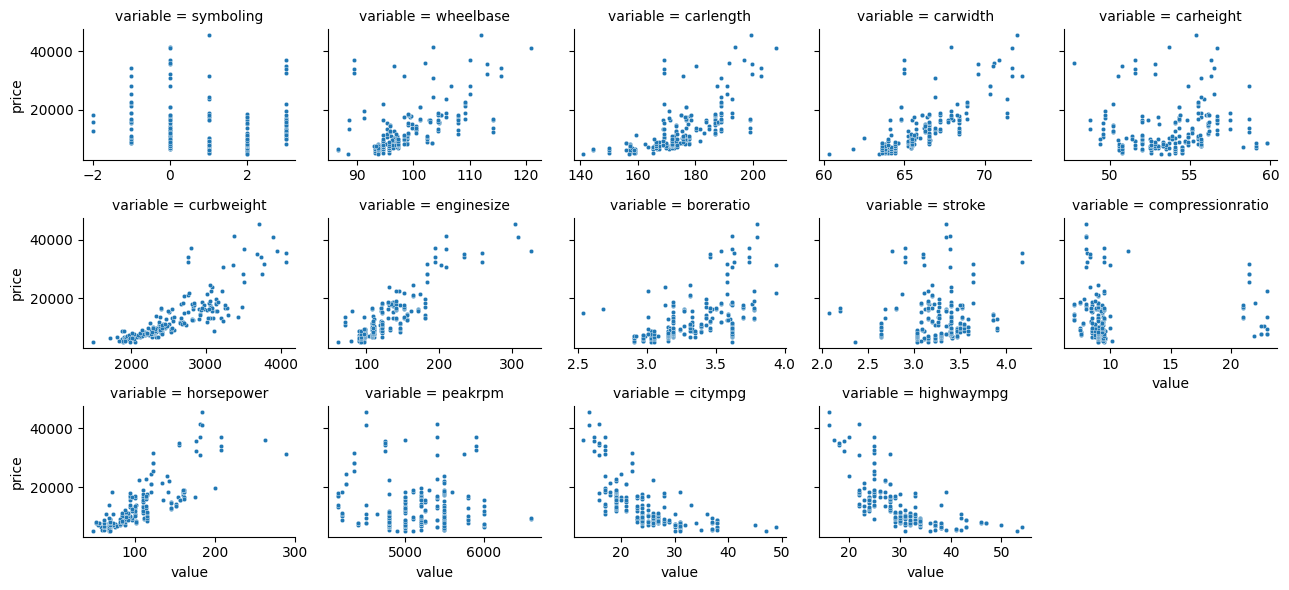

In [21]:
g = sns.FacetGrid(data=_df, col='variable', col_wrap=5, sharex=False, height=2, aspect=1.3)
g.map(sns.scatterplot, 'value', 'price', s=10);

----

In [22]:
sns.FacetGrid.map


<function seaborn.axisgrid.FacetGrid.map(self, func, *args, **kwargs)>

c) Do the same thing for categorical variables. You can exclude `CarName` from overview. Also, have in mind you have more than one way at your disposal.

In [23]:
categorical_variable = df.select_dtypes(include='object').columns.to_list()
categorical_variable

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [31]:
_df = df[categorical_variable]
_df['price'] = df['price']
_df

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,price
0,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi,13495.0
1,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi,16500.0
2,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,16500.0
3,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi,13950.0
4,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi,17450.0
...,...,...,...,...,...,...,...,...,...,...,...
200,volvo 145e (sw),gas,std,four,sedan,rwd,front,ohc,four,mpfi,16845.0
201,volvo 144ea,gas,turbo,four,sedan,rwd,front,ohc,four,mpfi,19045.0
202,volvo 244dl,gas,std,four,sedan,rwd,front,ohcv,six,mpfi,21485.0
203,volvo 246,diesel,turbo,four,sedan,rwd,front,ohc,six,idi,22470.0


In [25]:
# lets melt it to make format > wide to long 

melted_df= _df.melt(id_vars='price',value_vars=categorical_variable[1:-1])
melted_df

,price,variable,value
0,13495.0,fueltype,gas
1,16500.0,fueltype,gas
2,16500.0,fueltype,gas
3,13950.0,fueltype,gas
4,17450.0,fueltype,gas
...,...,...,...
1635,16845.0,cylindernumber,four
1636,19045.0,cylindernumber,four
1637,21485.0,cylindernumber,six
1638,22470.0,cylindernumber,six


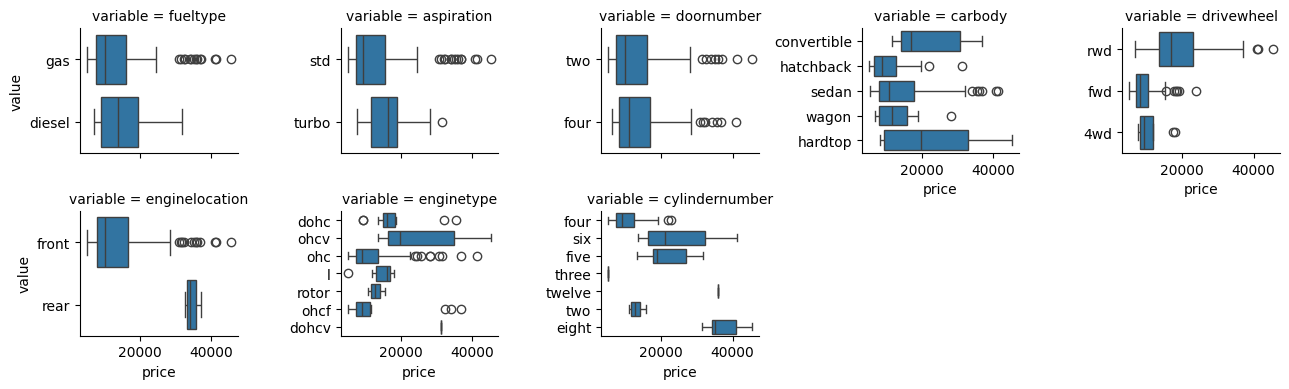

In [ ]:
g = sns.FacetGrid(data=melted_df, col='variable', col_wrap=5, sharey=False, height=2, aspect=1.3) #share(x) and share(y) x,y axis!
g.map(sns.boxplot, 'price', 'value' );

---

d) Figure out the way to get Peason's correlation coefficient between each of the numerical variables. Remember, it has its statistic value and p-value. 

In [44]:
df[numerical_variables].corr(method='pearson')
    

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.000000,-0.151621,0.129729,0.170636,0.052387,0.255960,0.071962,-0.033930,0.260064,-0.160824,0.150276,-0.015006,-0.203789,0.015940,0.011255,-0.109093
symboling,-0.151621,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,0.129729,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.170636,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.052387,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.255960,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.071962,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.033930,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.260064,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.160824,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443


---

e) Plot these coefficients using `heatmap` chart from `seaborn` library.

<Axes: >

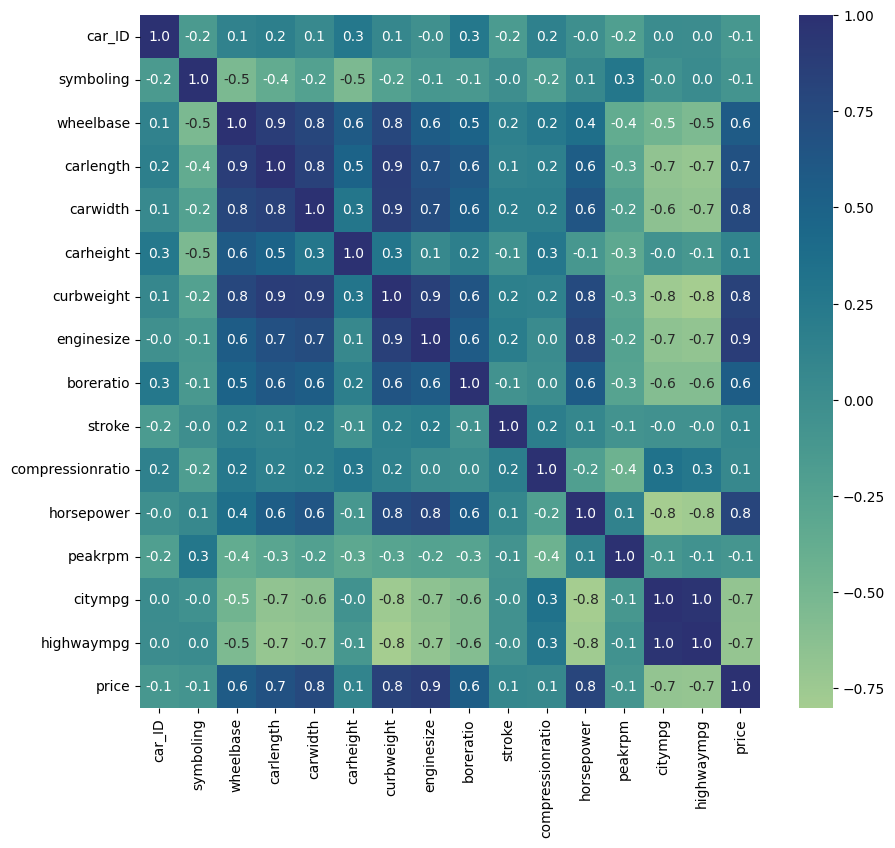

In [73]:
df_pearson = df[numerical_variables].corr(method='pearson')
plt.figure(figsize=(10,9))
sns.heatmap(data=df_pearson,cmap='crest',cbar=True,cbar_ax=None,annot=True,fmt='.1f')

---

But first explanation (chatGPT):

###  **Hypothesis Testing: Alpha (α), Beta (β), and Statistical Power**

---

####  What is Hypothesis Testing?

When conducting a hypothesis test, we try to determine if there's enough evidence to reject a **null hypothesis (H₀)** in favor of an **alternative hypothesis (H₁)**. Errors can occur in this decision process, which are quantified by **alpha (α)** and **beta (β)**.

---

###  Key Concepts

#### **Alpha (α) – Type I Error**
- **Definition**: Probability of rejecting **H₀** when **H₀ is actually true**.
- **Also known as**: **Significance level**.
- **Common value**: 0.05 (5%)
- **Example**: False positive – concluding there is an effect when there isn’t one.
- **Impact**: You claim there’s a difference or effect, but it's due to chance.

---

#### **Multiple Hypothesis Testing**
- When you run **multiple tests**, the chance of making at least one Type I error increases.
- **Solution**: Apply a **Bonferroni correction**:
  - Divide α by the number of comparisons.
  - Example: 5 tests → α = 0.05 / 5 = **0.01 per test**

---

#### **Beta (β) – Type II Error**
- **Definition**: Probability of **failing to reject H₀** when **H₀ is false**.
- **Acceptable range**: 0.05 to 0.20
- **Example**: False negative – failing to detect a real effect.
- **Impact**: You miss a significant finding that actually exists.

---

#### **Power of a Test**
- **Definition**: The ability of a test to correctly detect an effect when there is one.
- **Formula**:


###  Decision Matrix

|                             | **Reject H₀**                | **Fail to Reject H₀**       |
|-----------------------------|------------------------------|------------------------------|
| **H₀ is False** (Effect exists) | ✅ **Correct Decision**         | ❌ **Type II Error (β)**      |
| **H₀ is True** (No effect)     | ❌ **Type I Error (α)**         | ✅ **Correct Decision**       |



- **Type I Error (α)**: Test result says positive (effect), but it's actually negative — *false alarm*.
- **Type II Error (β)**: Test result says negative (no effect), but it's actually positive — *missed detection*.


---


f) Let's define our significancy level $\alpha$ at 0.05. Use `heatmap` to plot which feature pairs have their Pearsons' correlation significant.

In [211]:
# Okay so i am thinking about looping over the rows and columns of the data frame object (no iteration over the sns.heatmap because it's just the visual!)

data = []

for i1 in numerical_variables[1:]:
    for i2 in numerical_variables[1:]:
        data.append({'name_a': i1, 'name_b': i2, 'pvalue': stats.pearsonr(df[i1], df[i2]).pvalue})


In [212]:
_df = pd.DataFrame(data).pivot(index='name_a', columns='name_b', values='pvalue') < 0.05
_df = _df[numerical_variables[1:]]
_df = _df.T[numerical_variables[1:]]

In [197]:
pivoted_df = pd.DataFrame(data).pivot(index= 'name_a1',columns='name_a2', values='pvalue')
pivoted_df = pivoted_df[numerical_variables[1:]]
pivoted_df = pivoted_df.T[numerical_variables[1:]]
pivoted_df

 # 15,15 shape , without car_ID 

name_a1,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
name_a2,,,,,,,,,,,,,,,
symboling,"(1.0, 0.0)","(-0.5319536816234919, 2.2558943838906417e-16)","(-0.3576115226172909, 1.4093386795178178e-07)","(-0.23291906097426612, 0.0007770414411508319)","(-0.5410381997685205, 5.5313497254694967e-17)","(-0.22769058847745233, 0.0010258741249050945)","(-0.10578970928966415, 0.13113130665107275)","(-0.1300513596849308, 0.06308851912349688)","(-0.008735140673330664, 0.9010731610101951)","(-0.17851508438647612, 0.010439476220905295)","(0.07087272404244954, 0.31258703796276205)","(0.27360624512880943, 7.202290445666573e-05)","(-0.03582262794554107, 0.6101009021617838)","(0.03460600071191989, 0.6222949882287216)","(-0.07997822464270346, 0.25431175848635096)"
wheelbase,"(-0.5319536816234919, 2.2558943838906417e-16)","(1.0, 0.0)","(0.8745874759642631, 9.699226565149947e-66)","(0.7951436436169681, 5.612751951963328e-46)","(0.5894347616933504, 1.4379848267007034e-20)","(0.7763863277822107, 1.439876973932406e-42)","(0.5693286815396976, 5.233095749548532e-19)","(0.4887498752756665, 1.046553178519844e-13)","(0.16095904729726299, 0.02113610245776347)","(0.24978584518743382, 0.0003039091859680725)","(0.3532944782054003, 2.036049742021543e-07)","(-0.36046874776149135, 1.1014382254809421e-07)","(-0.4704136134054834, 1.103347460501212e-12)","(-0.5440819234088284, 3.4209173574234364e-17)","(0.57781559829215, 1.18282048633774e-19)"
carlength,"(-0.3576115226172909, 1.4093386795178178e-07)","(0.8745874759642631, 9.699226565149947e-66)","(0.9999999999999997, 0.0)","(0.8411182684818451, 4.332386050436316e-56)","(0.49102945750421423, 7.731666026743887e-14)","(0.8777284608306425, 8.728145747823388e-67)","(0.6833598726519033, 1.4963342221184378e-29)","(0.606454357984969, 5.609641439612173e-22)","(0.12953261112791198, 0.064156541033446)","(0.15841370644020653, 0.023291800207480153)","(0.5526229673941834, 8.651948061425604e-18)","(-0.287242202818439, 2.968411369142106e-05)","(-0.6709086615585711, 3.595528842225762e-28)","(-0.7046616035425505, 4.428947854258049e-32)","(0.6829200156779623, 1.6787066240745933e-29)"
carwidth,"(-0.2329190609742661, 0.0007770414411508319)","(0.7951436436169682, 5.612751951963328e-46)","(0.8411182684818452, 4.33238605043576e-56)","(1.0, 0.0)","(0.2792103211097493, 5.031445870167135e-05)","(0.8670324646791239, 2.460481311724944e-63)","(0.7354334047796368, 3.685904171717947e-36)","(0.5591499086023912, 2.946035645862702e-18)","(0.18294169251421813, 0.008652060221077422)","(0.18112862677079744, 0.009348405088677448)","(0.6407320755722925, 4.3579813683309605e-25)","(-0.22001230306613678, 0.0015256215485197897)","(-0.642704340710897, 2.80724860594112e-25)","(-0.6772179173117137, 7.321537056467374e-29)","(0.7593252997415116, 9.627437876118833e-40)"
carheight,"(-0.5410381997685205, 5.5313497254694967e-17)","(0.5894347616933504, 1.4379848267007034e-20)","(0.49102945750421423, 7.731666026743887e-14)","(0.27921032110974925, 5.0314458701672016e-05)","(0.9999999999999998, 0.0)","(0.2955717261948497, 1.688129362856675e-05)","(0.06714874180270554, 0.33875655856573494)","(0.17107092150966002, 0.014187059382339577)","(-0.05530667369878782, 0.4309119574976802)","(0.26121422631993957, 0.000154923467571102)","(-0.10880205898413592, 0.12044788181960107)","(-0.32041072381018654, 2.8187666594339247e-06)","(-0.04863962869509294, 0.4885824701036939)","(-0.10735762697679838, 0.12548303400469013)","(0.11933622657049445, 0.08832832352275008)"
curbweight,"(-0.22769058847745233, 0.0010258741249050945)","(0.776386327782211, 1.4398769739322782e-42)","(0.8777284608306425, 8.728145747823388e-67)","(0.8670324646791239, 2.460481311724944e-63)","(0.2955717261948497, 1.688129362856675e-05)","(0.9999999999999999, 0.0)","(0.8505940734262769, 1.4045805990464736e-58)","(0.6484797487010712, 7.600393794975373e-26)","(0.16879003525191977, 0.015549891064249742)","(0.15136174003093078,

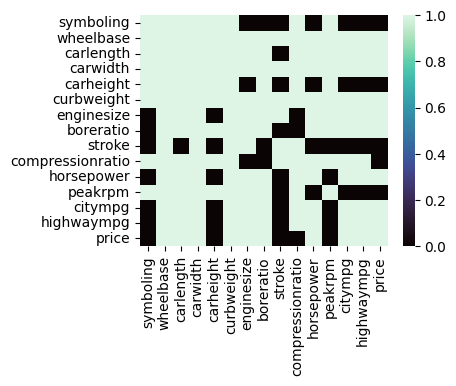

In [216]:
plt.figure(figsize=(4, 3))
sns.heatmap(_df,cmap='mako');
plt.xlabel('')
plt.ylabel('');

---

2. Since there is a lot of both numerical and categorical variables, let's start with simple linear regression.

In [219]:
# - fitting the linear model to the data
linear_model = smf.ols(formula='price ~ fueltype', data=df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.293
Date:                Sun, 13 Apr 2025   Prob (F-statistic):              0.132
Time:                        11:28:06   Log-Likelihood:                -2131.3
No. Observations:                 205   AIC:                             4267.
Df Residuals:                     203   BIC:                             4273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.584e+04   1780.728     

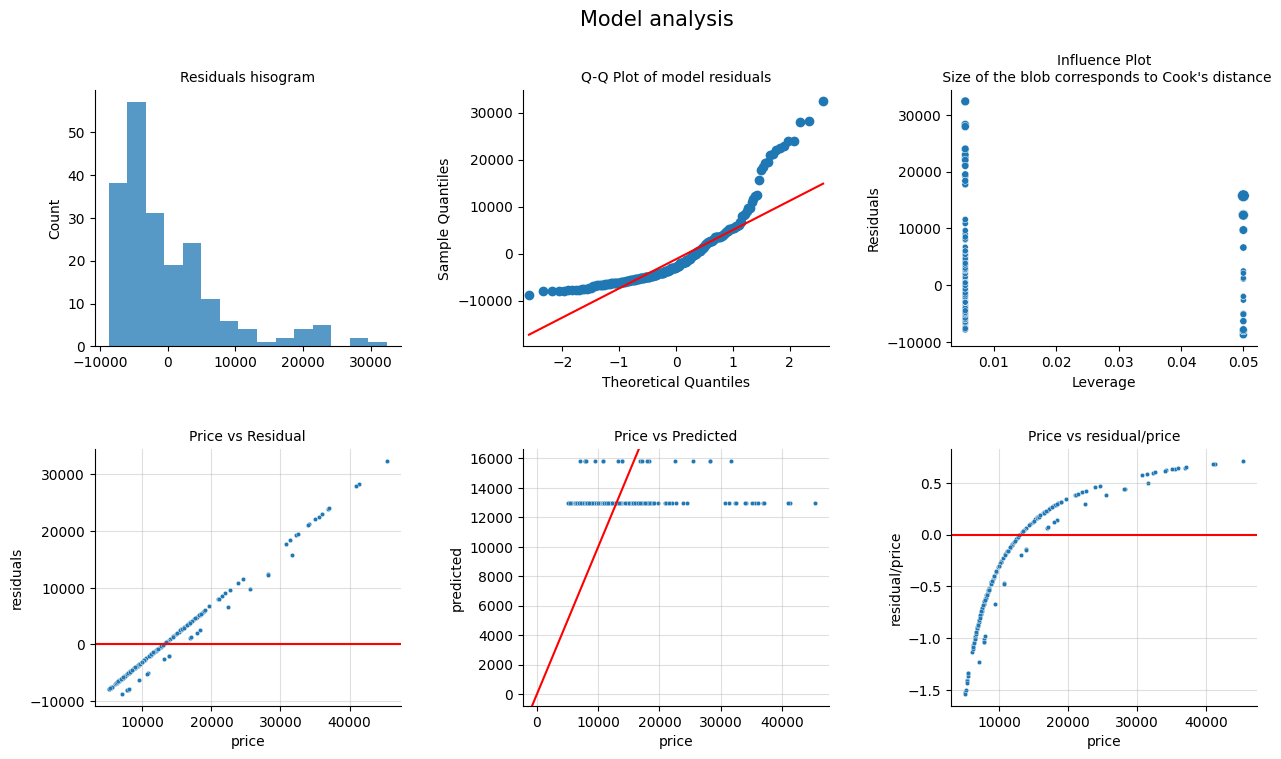

In [220]:
plot_model_analysis(linear_model, df['price'])

**Conclusion**

Short version: Our model is not statistically significant. 

Long version: 
- Null hypothesis (H0) says β1 = β2 = ... = 0 (regression model does not exist). 
- Alternative hypothesis H1 says there is at least one regression coefficient that is different from 0.
- By looking at the F-statistic and it's probability (p-value) we should either have a proof for rejecting H0 or not. In our case we do not have evidence to be able to reject H0 and we say this regression model is not good i.e. there is no relationshipt between predictor variable and target variable.

---

b) Regress `price` on categorical variable `carbody` and describe the results. Use category *hatcback* as reference.

In [221]:
# - fitting the linear model to the data
linear_model = smf.ols(formula='price ~ C(carbody, Treatment(reference="hatchback"))', data=df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     8.032
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           5.03e-06
Time:                        11:30:23   Log-Likelihood:                -2117.2
No. Observations:                 205   AIC:                             4244.
Df Residuals:                     200   BIC:                             4261.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

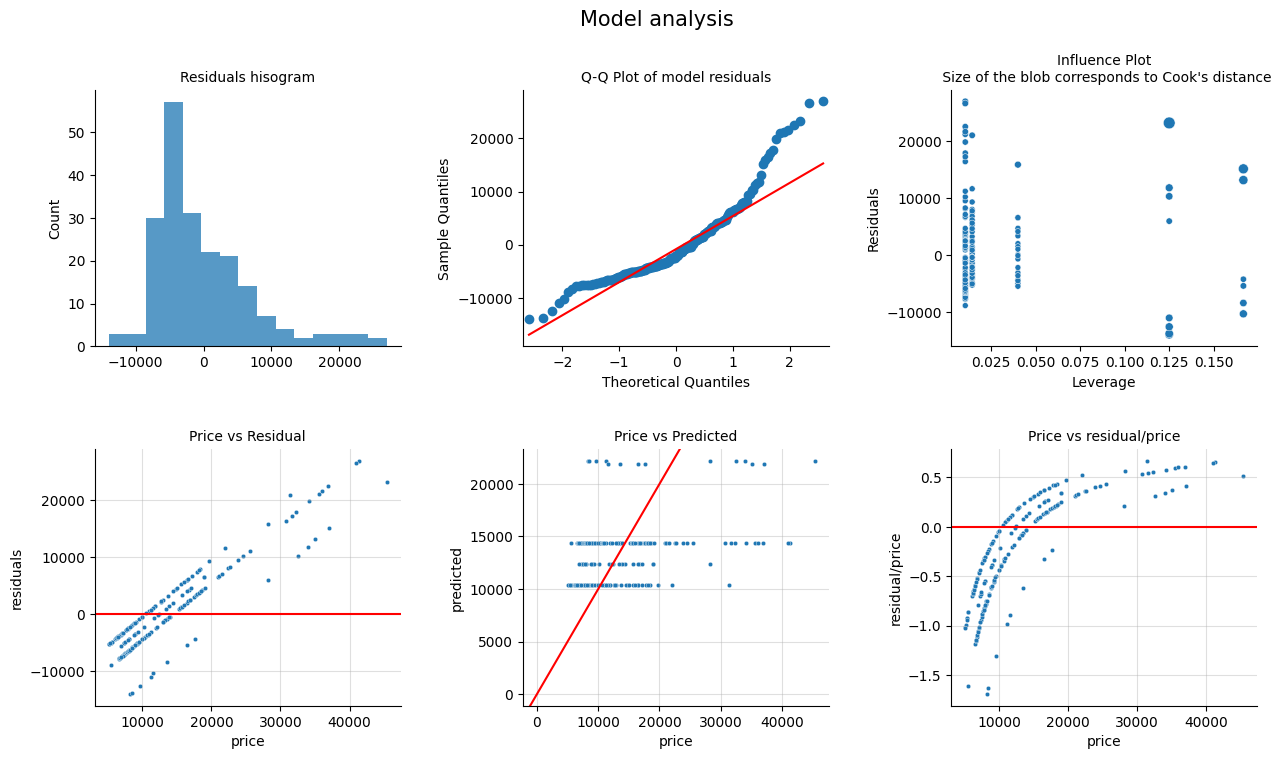

In [222]:
plot_model_analysis(linear_model, df['price'])

**Conclusion**

This model's F-statistic probability (p-value) is way below 0.05 alpha value. Based on this we have the evidence to reject H0 and say that at least one of the model's coefficients has it's value different from 0. Therefore, we continue with interpreting the rest of the regression report.

Model has very low value of R2. It's not that good at describing the variance in price based on `carbody` variable.

Based on p-values and stdandard errors of coefficients, we can see that most of the coefficients are statistically significant (except for coefficient for *wagon* category).

---

c) Let's try multiple linear regression model now. First use only numerical features when modeling and describe OLS regression results and results of visual inspection.

In [228]:
numerical_variables

fomula_features = ' + '.join(numerical_variables[1:-1])
fomula_features

'symboling + wheelbase + carlength + carwidth + carheight + curbweight + enginesize + boreratio + stroke + compressionratio + horsepower + peakrpm + citympg + highwaympg'

In [232]:
linear_model=smf.ols(formula='price ~ ' + fomula_features,data=df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     78.05
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           7.97e-71
Time:                        11:34:49   Log-Likelihood:                -1936.7
No. Observations:                 205   AIC:                             3903.
Df Residuals:                     190   BIC:                             3953.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -5.165e+04   1.57e+04     -3.299      0.001   -8.25e+04   -2.08e+04
symboling          285.8829    243.335      1.175      0.242    -194.101     765.867
wheelbase          167.6990    107.450      1.561      0.120     -44.250     379.648
carlength          -94.8179     55.502     -1.708      0.089    -204.297      14.661
carwidth           466.6185    247.995      1.882      0.061     -22.559     955.796
carheight          194.7522    138.223      1.409      0.160     -77.897     467.402
curbweight           1.8776      1.736      1.082      0.281      -1.546       5.301
enginesize         116.7820     13.831      8.443      0.000      89.500     144.064
boreratio         -984.4276   1194.709     -0.824      0.411   -3341.025    1372.169
stroke           -3056.1620    778.046     -3.928      0.000   -4590.881   -1521.443
compressionratio   286.4752     83.425      3.434      0.001     121.918     451.033
horsepower          32.5014     16.264      1.998      0.047       0.420      64.583
peakrpm              2.3582      0.670      3.518      0.001       1.036       3.680
citympg           -286.9397    179.856     -1.595      0.112    -641.710      67.831
highwaympg         191.3036    159.902      1.196      0.233    -124.108     506.716
==============================================================================
Omnibus:                       24.845   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.581
Skew:                           0.412   Prob(JB):                     8.64e-18
Kurtosis:                       5.919   Cond. No.                     4.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

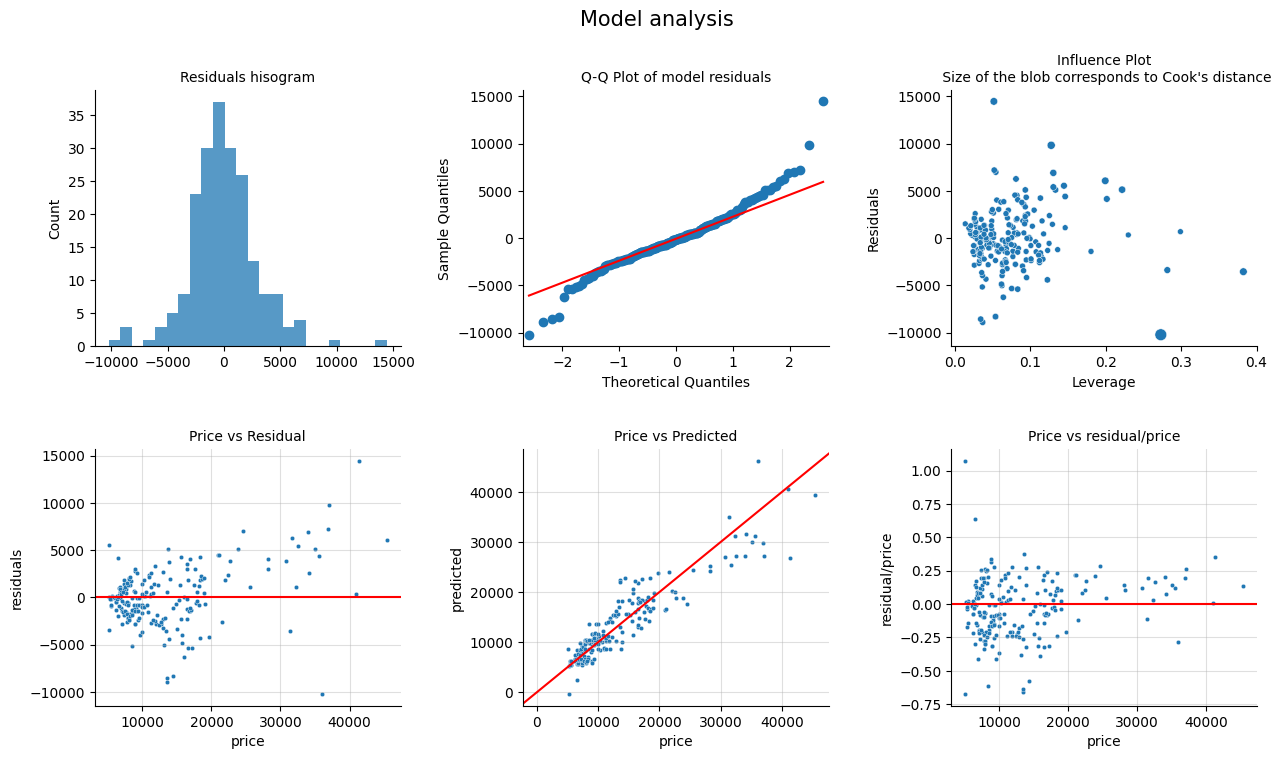

In [234]:
plot_model_analysis(linear_model,target=df['price'])

**Conclusion**

This model's F-statistic probability (p-value) is way below 0.05 alpha value. Based on this we can reject null hypothesis and say that there is at least one model's coefficient that is different from 0.

Based on R2 value of 0.852 we can say this model is pretty good at describing variance in price by numerical predictors.

Most model's coefficients have statistically significant effect on describing price.

Residual's histogram and QQ plot show that residuals have distribution very similar to the normal distribution.

Predicted vs residual shows something that looks like a heteroskedastisity. This can bee seen on Price vs. Predicted plot as well.

However, the last plot shows ratio between residual/price and price, and this gives insight in percentage of errors for each prediction. Here we see that most of the prediction errors are in +-25% range.

---

d) Get the VIF for numerical features and explain the findings.

In [235]:
### --- Variance Inflation Factors (VIFs)

# - appending the columns of ones to the predictors' data
model_frame_predictors = sm.add_constant(df[numerical_variables[1:-1]])
model_frame_predictors

,const,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1.0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,1.0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,1.0,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26
3,1.0,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30
4,1.0,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,9.5,114,5400,23,28
201,1.0,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25
202,1.0,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23
203,1.0,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,23.0,106,4800,26,27


In [258]:
# The lower bound of VIF is 1; 
# - there is no upper bound;
# - VIF > 2 indicates high variance inflation

vif = [variance_inflation_factor(model_frame_predictors.values,i) for i in range(1,len(numerical_variables[1:-1])+1)]
vif = np.array(vif).reshape(1,-1)
df_vifs = pd.DataFrame(vif, columns=numerical_variables[1:-1]).T
df_vifs.rename(columns={0:'vif'}).sort_values(ascending=True,by='vif')


,vif
stroke,1.196447
symboling,1.845435
peakrpm,2.054716
boreratio,2.104263
compressionratio,2.206752
carheight,2.292633
carwidth,5.688037
enginesize,6.667017
horsepower,8.313121
wheelbase,8.414016


Conclusion: If we say that VIF > 2 is a sign of variance inflation, we can see that most of our predictors have their variance inflated due to collinearity with other predictors. One interesting thing here are top 2 predictors (`citympg` and `highwaympg`), that have high VIF. This matches with findinds from the heatmap of correlations. We saw previously that Pearson's correlation coefficient between these two is 0.97!

---

e) Let's try multiple linear regression model, but now with only categorical features when modeling and describe OLS regression results and results of visual inspection.

In [271]:
formula_example = " + ".join(categorical_variable[1:])
linear_model = smf.ols(formula='price ~' + formula_example,data=df).fit()

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     37.81
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           1.40e-59
Time:                        17:07:11   Log-Likelihood:                -1936.5
No. Observations:                 205   AIC:                             3929.
Df Residuals:                     177   BIC:                             4022.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 2.625e+04   2114.645     12.412      0.000    2.21e+04    3.04e+04
fueltype[T.gas]           1.274e+04   1280.854      9.943      0.000    1.02e+04    1.53e+04
aspiration[T.turbo]       3482.2731    833.641      4.177      0.000    1837.119    5127.427
doornumber[T.two]        -1206.8598    729.375     -1.655      0.100   -2646.251     232.531
carbody[T.hardtop]       -2200.0315   1839.193     -1.196      0.233   -5829.601    1429.538
carbody[T.hatchback]     -2280.7777   1605.570     -1.421      0.157   -5449.302     887.746
carbody[T.sedan]         -1796.3100   1674.226     -1.073      0.285   -5100.323    1507.703
carbody[T.wagon]         -2314.0287   1822.205     -1.270      0.206   -5910.071    1282.014
drivewheel[T.fwd]          553.9690   1330.570      0.416      0.678   -2071.854    3179.792
drivewheel[T.rwd]         5079.9441   1455.896      3.489      0.001    2206.796    7953.092
enginelocation[T.rear]    8986.3805   2743.836      3.275      0.001    3571.537    1.44e+04
enginetype[T.dohcv]      -1.155e+04   4130.894     -2.796      0.006   -1.97e+04   -3395.933
enginetype[T.l]           1197.1210   1642.680      0.729      0.467   -2044.638    4438.880
enginetype[T.ohc]         2271.0744   1177.975      1.928      0.055     -53.609    4595.758
enginetype[T.ohcf]        1927.0261   1618.469      1.191      0.235   -1266.954    5121.006
enginetype[T.ohcv]       -5484.6207   1646.274     -3.332      0.001   -8733.473   -2235.769
enginetype[T.rotor]      -1.365e+04   2065.447     -6.610      0.000   -1.77e+04   -9575.717
cylindernumber[T.five]   -2.311e+04   2650.445     -8.721      0.000   -2.83e+04   -1.79e+04
cylindernumber[T.four]   -3.133e+04   2432.478    -12.881      0.000   -3.61e+04   -2.65e+04
cylindernumber[T.six]    -2.015e+04   2115.352     -9.525      0.000   -2.43e+04    -1.6e+04
cylindernumber[T.three]  -3.159e+04   4445.692     -7.105      0.000   -4.04e+04   -2.28e+04
cylindernumber[T.twelve] -1948.4230   3790.030     -0.514      0.608   -9427.884    5531.038
cylindernumber[T.two]    -1.365e+04   2065.447     -6.610      0.000   -1.77e+04   -9575.717
fuelsystem[T.2bbl]        -508.4434   1092.041     -0.466      0.642   -2663.540    1646.654
fuelsystem[T.4bbl]       -1126.4096   3981.704     -0.283      0.778   -8984.133    6731.313
fuelsystem[T.idi]         1.351e+04   1277.901     10.573      0.000     1.1e+04     1.6e+04
fuelsystem[T.mfi]         2494.1443   3546.031      0.703      0.483   -4503.796    9492.085
fuelsystem[T.mpfi]        2373.5904   1167.144      2.034      0.043      70.282    4676.899
fuelsystem[T.spdi]          28.7713   1653.654      0.017      0.986   -3234.645    3292.188
fuelsystem[T.spfi]        -465.5577   3525.368     -0.132      0.895   -7422.720    6491.605
==============

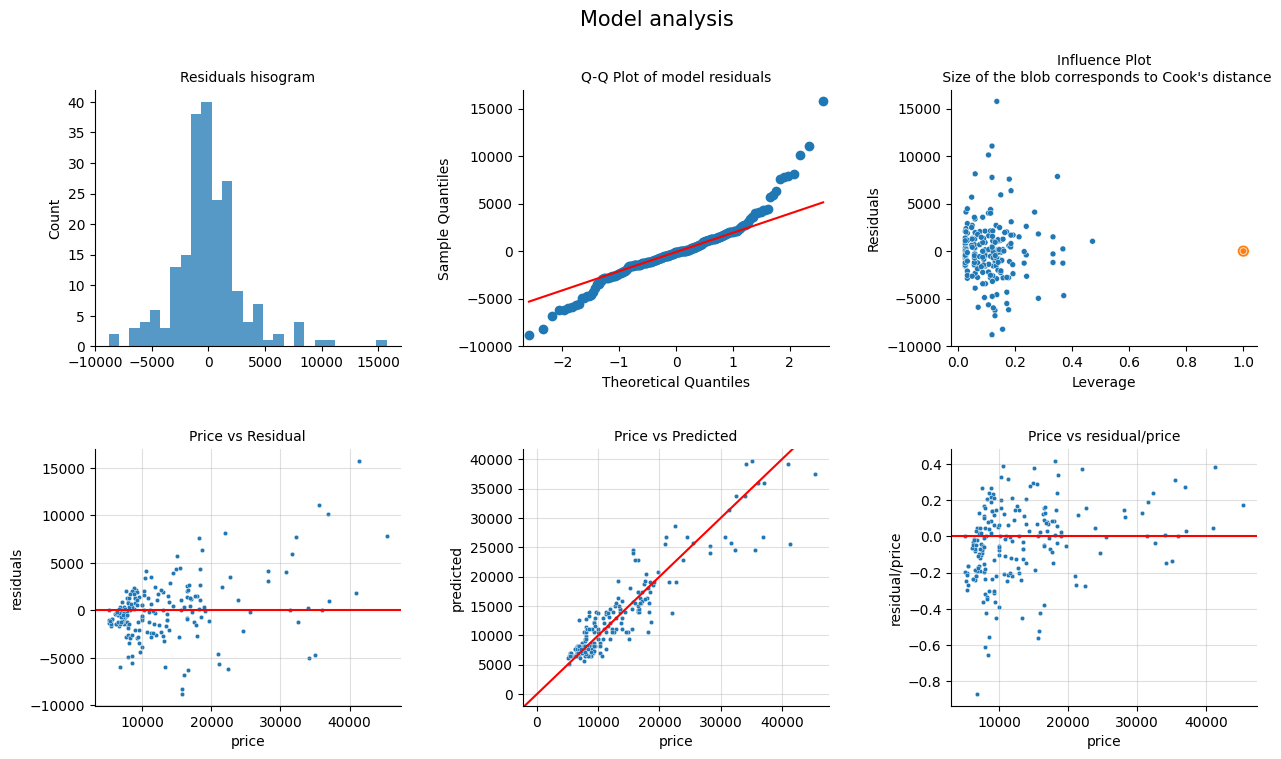

In [272]:
plot_model_analysis(linear_model,target=df['price'])

**Conclusion**

This model's F-statistic probability (p-value) is way below 0.05 alpha value. Based on this we can reject null hypothesis and say that there is at least one model's coefficient that is different from 0.

Based on R2 value of 0.852 we can say this model is pretty good at describing variance in price by numerical predictors.

Most model's coefficients have statistically significant effect on describing price.

Residual's histogram and QQ plot show that residuals have distribution very similar to the normal distribution.

Predicted vs residual shows something that looks like a heteroskedastisity. This can bee seen on Price vs. Predicted plot as well.

However, the last plot shows ratio between residual/price and price, and this gives insight in percentage of errors for each prediction. Here we see that most of the prediction errors are in +-40% range.

---

f) Do the regression analysis for the model that encompasses all of the predictors. Describe the results and make conclusions.

In [276]:
predictors_list = numerical_variables[1:-1] + categorical_variable[1:]

In [ ]:
fomula_features = ' + '.join(predictors_list)
fomula_features


AttributeError: 'str' object has no attribute 'items'

In [281]:
# - fitting the linear model to the data
linear_model = smf.ols(formula='price ~ ' + fomula_features, data=df).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     61.79
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           4.86e-80
Time:                        17:13:11   Log-Likelihood:                -1844.9
No. Observations:                 205   AIC:                             3774.
Df Residuals:                     163   BIC:                             3913.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.876e+04   1.02e+04     -1.844      0.067   -3.89e+04    1333.403
fueltype[T.gas]          -1.527e+04   5389.519     -2.833      0.005   -2.59e+04   -4626.644
aspiration[T.turbo]       1626.0175    885.607      1.836      0.068    -122.725    3374.760
doornumber[T.two]          187.6006    585.406      0.320      0.749    -968.356    1343.557
carbody[T.hardtop]       -3207.0350   1375.969     -2.331      0.021   -5924.058    -490.012
carbody[T.hatchback]     -3280.8341   1222.941     -2.683      0.008   -5695.684    -865.985
carbody[T.sedan]         -2151.5954   1332.017     -1.615      0.108   -4781.830     478.639
carbody[T.wagon]         -3265.6309   1455.394     -2.244      0.026   -6139.487    -391.775
drivewheel[T.fwd]           74.0486   1040.473      0.071      0.943   -1980.495    2128.592
drivewheel[T.rwd]         1032.7674   1205.057      0.857      0.393   -1346.768    3412.302
enginelocation[T.rear]    7695.0237   2535.529      3.035      0.003    2688.305    1.27e+04
enginetype[T.dohcv]      -7189.2910   4673.503     -1.538      0.126   -1.64e+04    2039.123
enginetype[T.l]          -1051.0793   1607.967     -0.654      0.514   -4226.211    2124.053
enginetype[T.ohc]         3125.6464    908.839      3.439      0.001    1331.031    4920.262
enginetype[T.ohcf]        1233.6574   1571.770      0.785      0.434   -1869.999    4337.314
enginetype[T.ohcv]       -5605.2579   1246.936     -4.495      0.000   -8067.488   -3143.027
enginetype[T.rotor]        -34.6261   2252.494     -0.015      0.988   -4482.456    4413.204
cylindernumber[T.five]   -9280.3650   2716.126     -3.417      0.001   -1.46e+04   -3917.036
cylindernumber[T.four]   -9879.0883   3054.385     -3.234      0.001   -1.59e+04   -3847.824
cylindernumber[T.six]    -6570.0303   2192.256     -2.997      0.003   -1.09e+04   -2241.148
cylindernumber[T.three]   -462.9157   4498.941     -0.103      0.918   -9346.636    8420.805
cylindernumber[T.twelve] -1.024e+04   4383.680     -2.336      0.021   -1.89e+04   -1584.328
cylindernumber[T.two]      -34.6261   2252.494     -0.015      0.988   -4482.456    4413.204
fuelsystem[T.2bbl]         -39.0684    891.987     -0.044      0.965   -1800.409    1722.272
fuelsystem[T.4bbl]       -1623.6205   2774.981     -0.585      0.559   -7103.166    3855.925
fuelsystem[T.idi]        -3493.4698   6881.659     -0.508      0.612   -1.71e+04    1.01e+04
fuelsystem[T.mfi]        -3479.7025   2589.965     -1.344      0.181   -8593.912    1634.507
fuelsystem[T.mpfi]        -244.3674   1000.854     -0.244      0.807   -2220.678    1731.943
fuelsystem[T.spdi]       -3026.7527   1381.549     -2.191      0.030   -5754.794    -298.712
fuelsystem[T.spfi]        -618.6902   2508.300     -0.247      0.805   -5571.641    4334.261
symboling     

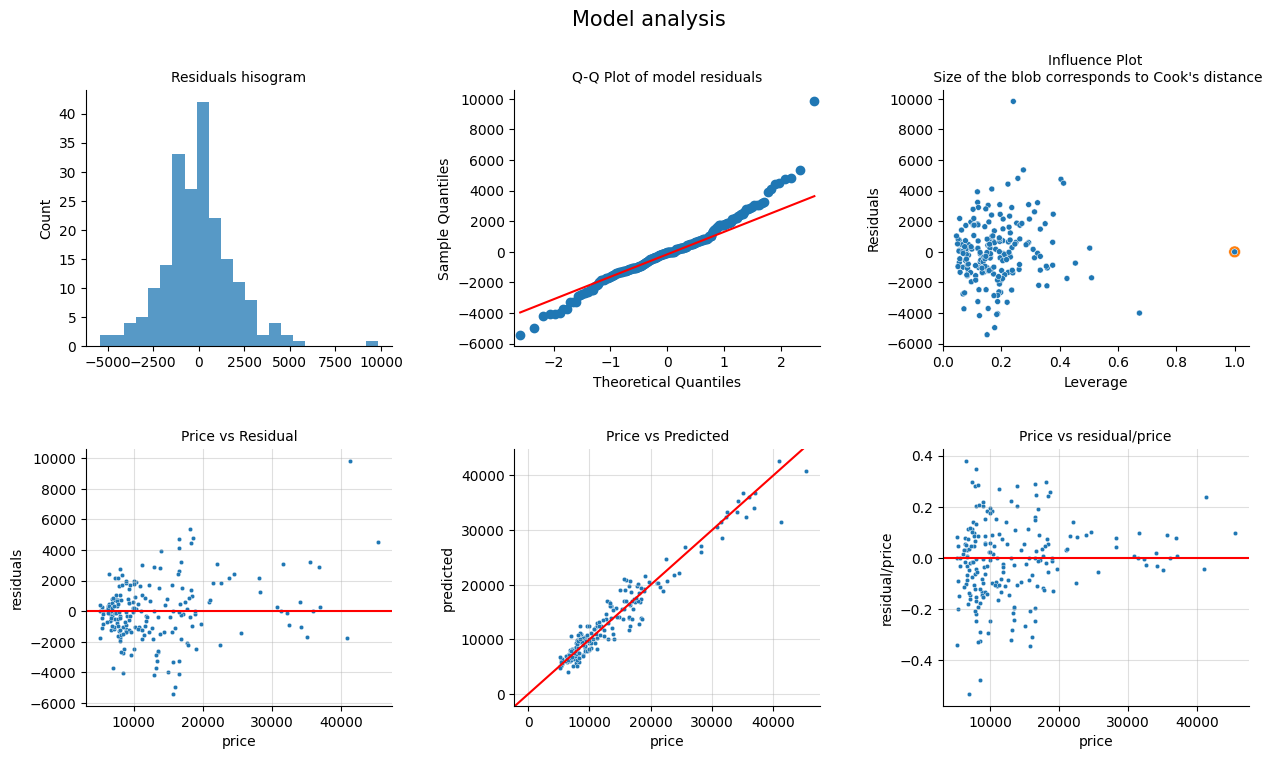

In [282]:
plot_model_analysis(linear_model,target=df['price'])

**Conclusion**

This model's F-statistic probability (p-value) is way below 0.05 alpha value. Based on this we can reject null hypothesis and say that there is at least one model's coefficient that is different from 0.

Based on R2 value of 0.94 we can say this model is even better than previous models at describing variance in price by predictors.

There is a lot of model's coefficients that have statistically significant effect on describing price.

Residual's histogram and QQ plot show that residuals have distribution very similar to the normal distribution.

Predicted vs residual shows something that looks like a heteroskedastisity. This can bee seen on Price vs. Predicted plot as well.

However, the last plot shows ratio between residual/price and price, and this gives insight in percentage of errors for each prediction. Here we see that most of the prediction errors are in +-20% range.

---

3. Use `sklearn` to fit the linear regression model, get the predictions, plot the Price vs. Predicted chart and calculate R2 metric for the prediction results.

In [320]:
numerical_data = df[numerical_variables[1:-1]]
categorical_data = pd.get_dummies(df[categorical_variable[1:]])
X = pd.concat([df[numerical_variables[1:-1]], pd.get_dummies(df[categorical_variable[1:]])], axis=1)
y = df['price']

In [321]:
lr=LinearRegression()
lr.fit(X,y)

LinearRegression()

In [ ]:
from sklearn.metrics import r2_score
y_pred = lr.predict(X)
r2_score(y, y_pred)
# 0.9395461533262985

0.9395461533262985

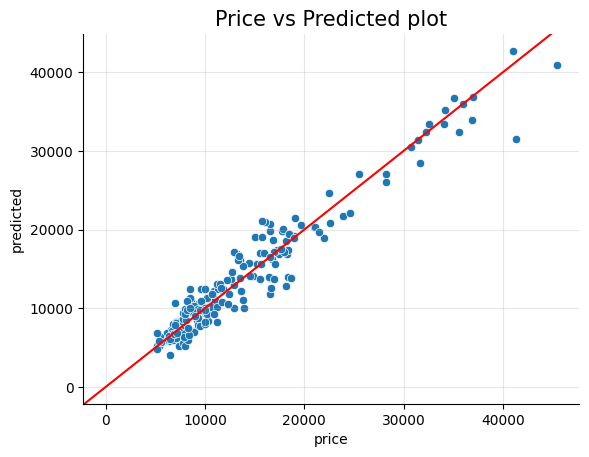

In [366]:
sns.scatterplot(x=y, y=y_pred)
sns.despine()
plt.grid(alpha=.3)

# You cannot use both xy2 and slope at the same time — choose one method of defining the line's direction.
plt.axline((0,0),(1,1),c='r') #xy1 (tuple of 2 numbers-> point on the line),xy2 optional but mutually exclusive with the slope. #When you use both xy1 and xy2, the function automatically calculates the slope between them.
plt.title('Price vs Predicted plot', fontsize=15)
plt.xlabel('price')
plt.ylabel('predicted');

In [367]:
df_importances = pd.DataFrame(list(zip(lr.coef_, lr.feature_names_in_)))
df_importances = df_importances.rename(columns={0: 'coefficient', 1: 'feature'})
df_importances = df_importances.sort_values(by='coefficient', ascending=False)

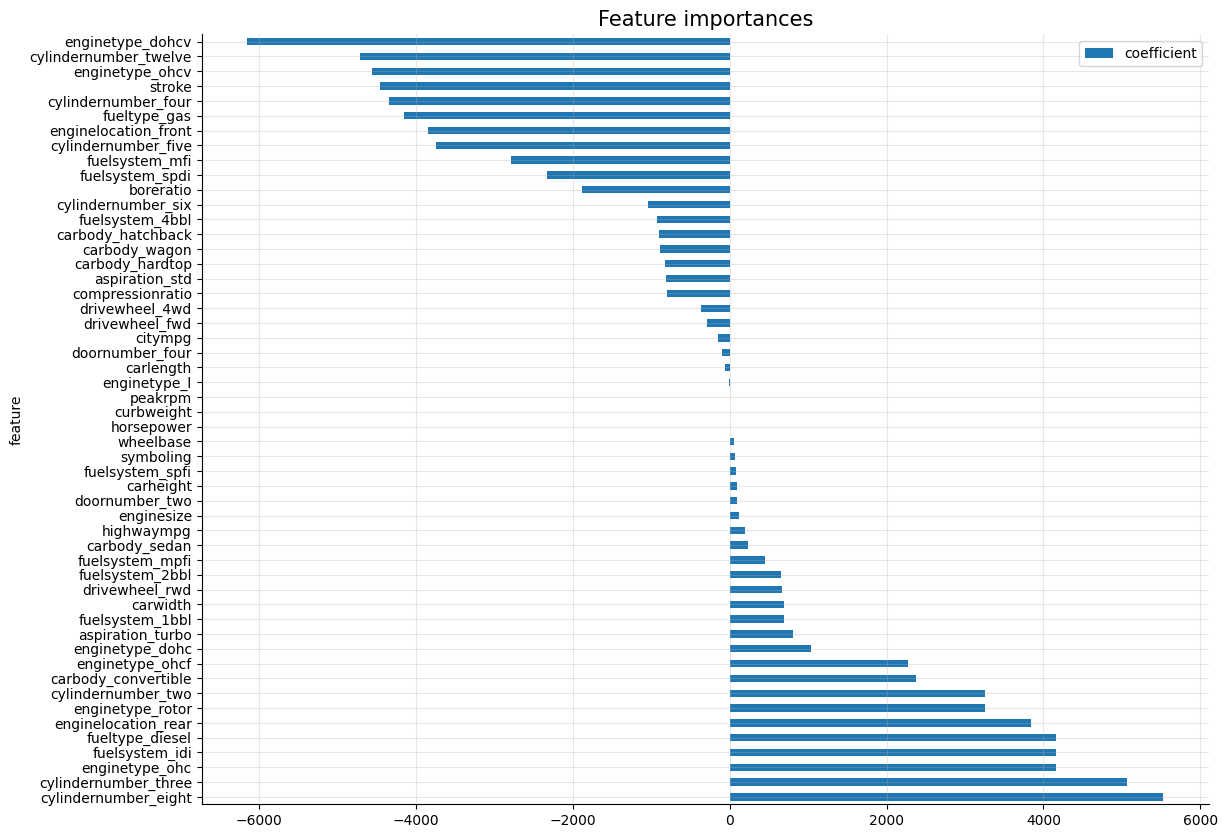

In [368]:
plt.figure(figsize=(13, 10))
df_importances.set_index('feature').plot(kind='barh', ax=plt.gca())
sns.despine()
plt.grid(alpha=.3);
plt.title('Feature importances', fontsize=15);

For each dummy encoded categorical variable, one of its values is taken for the base line. You have to be sure what category is base line so you can interpret these feature importances correctly.

### References
- [Interpreting Linear Regression Through statsmodels.summary()](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a)
- [Mastering f-statistics in Linear Regression: Formula, Examples](https://vitalflux.com/interpreting-f-statistics-in-linear-regression-formula-examples/amp/)

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>